# Tornado Forecasting using Prophet

https://facebook.github.io/prophet/

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from prophet import Prophet
import geopandas as gpd
from datetime import timedelta


import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
yf.pdr_override()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


### 1. Load the dataset

In [2]:
df = gpd.read_file("/history_tornado_1950_2022/1950-2021-torn-aspath.shp")

In [3]:
# create a timestamp column by combining the date and time columns
df['ts'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str))

In [4]:
df['count'] = 1

In [5]:
df = df[['ts', 'date', 'time', 'count', 'mag', 'fat', 'inj', 'loss', 'closs', 'geometry']]

In [6]:
# Use .replace() to set all values of -9 to 0.0
df = df.replace(-9, 0.0)

df[['mag', 'inj' ,'fat']] = df[['mag', 'inj' ,'fat']] * 1.0

In [7]:
df.set_index('ts', inplace=True)

### 2. Build out the timestamp list

In [8]:
event_lists = df.groupby(pd.Grouper(freq='D')).apply(lambda x: x.index.to_list())


In [10]:
event_lists_df = event_lists.to_frame(name='event_timestamps').reset_index()

In [11]:
event_lists_df.to_csv('days_between.csv')

In [14]:
event_lists_df.to_csv('hours_between_event.csv')

### Build Frequency

In [323]:
event_counts = df.resample(rule='D').sum()

In [324]:
event_counts.reset_index(inplace=True)

In [325]:
event_counts.rename(columns={'ts': 'date'}, inplace=True)
event_counts.drop(columns=['mag','fat','inj','loss','closs'], inplace=True)

In [331]:
event_counts.head(10)

,date,count
0,1950-01-03,3
1,1950-01-04,0
2,1950-01-05,0
3,1950-01-06,0
4,1950-01-07,0
5,1950-01-08,0
6,1950-01-09,0
7,1950-01-10,0
8,1950-01-11,0
9,1950-01-12,0


In [332]:
event_counts = event_counts.rename(columns={'date': 'ds', 'count': 'y'})
event_counts

,ds,y
0,1950-01-03,3
1,1950-01-04,0
2,1950-01-05,0
3,1950-01-06,0
4,1950-01-07,0
...,...,...
26291,2021-12-27,0
26292,2021-12-28,0
26293,2021-12-29,8
26294,2021-12-30,4


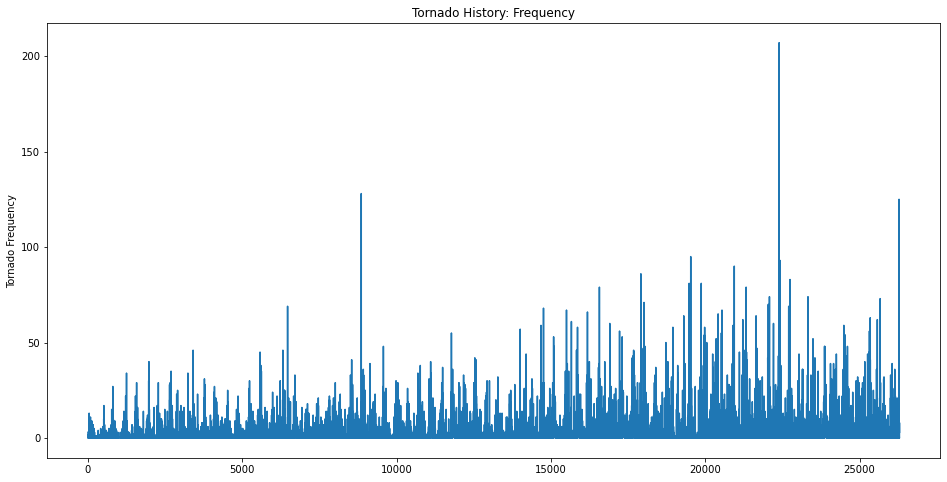

In [338]:
plt.figure(figsize=(16,8))
plt.plot(event_counts['y'])
plt.title('Tornado History: Frequency')
plt.ylabel('Tornado Frequency')
plt.show()

In [333]:
m = Prophet(daily_seasonality=True)
m.fit(event_counts)

Initial log joint probability = -13.686


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       80927.8    7.4107e-05        693.02      0.5342      0.5342      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         80930    0.00148665        393.97           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       80930.8   0.000705244        2159.2           1           1      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       80931.8   0.000110496       190.849      0.8579      0.8579      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499         80932   1.52498e-05       117.592      0.9755      0.9755      609   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     501     

In [334]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
26656,2022-12-27
26657,2022-12-28
26658,2022-12-29
26659,2022-12-30
26660,2022-12-31


In [335]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26656,2022-12-27,1.348377,-5.851979,8.877165
26657,2022-12-28,1.473561,-6.022732,8.448719
26658,2022-12-29,1.398535,-6.408517,8.594170
26659,2022-12-30,1.305885,-6.113541,8.699219
26660,2022-12-31,1.160280,-6.695815,8.187494


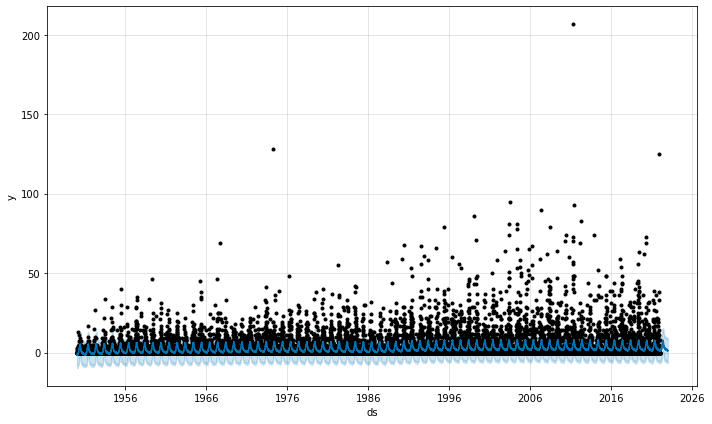

In [340]:
fig1 = m.plot(forecast)

### Build the other Indicators: Magnitude, Injury, Fatality, Loss, Crop Loss

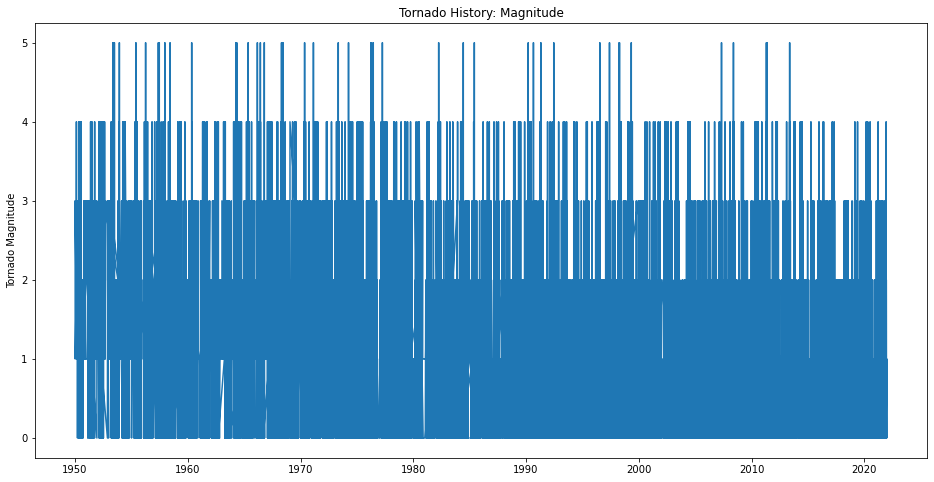

In [299]:
plt.figure(figsize=(16,8))
plt.plot(df['mag'])
plt.title('Tornado History: Magnitude')
plt.ylabel('Tornado Magnitude')
plt.show()

In [300]:
df.reset_index(inplace=True)

In [301]:
df = df.rename(columns={'ts': 'ds', 'mag': 'y'})
df

,ds,date,time,count,y,fat,inj,loss,closs,geometry
0,1950-10-01 21:00:00,1950-10-01,21:00:00,1,1.0,0.0,0.0,4.0,0.0,"LINESTRING (-102.52000 36.73000, -102.30000 36..."
1,1950-10-09 02:15:00,1950-10-09,02:15:00,1,3.0,0.0,3.0,5.0,0.0,"LINESTRING (-78.60000 34.17000, -78.59990 34.1..."
2,1950-11-20 02:20:00,1950-11-20,02:20:00,1,2.0,0.0,0.0,5.0,0.0,"LINESTRING (-87.20000 37.37000, -87.19990 37.3..."
3,1950-11-20 04:00:00,1950-11-20,04:00:00,1,1.0,0.0,0.0,5.0,0.0,"LINESTRING (-84.50000 38.20000, -84.49990 38.2..."
4,1950-11-20 07:30:00,1950-11-20,07:30:00,1,1.0,0.0,3.0,4.0,0.0,"LINESTRING (-89.13000 32.42000, -89.12990 32.4..."
...,...,...,...,...,...,...,...,...,...,...
67553,2021-09-08 15:32:00,2021-09-08,15:32:00,1,1.0,0.0,0.0,0.0,0.0,"LINESTRING (-77.00620 40.75860, -76.99590 40.7..."
67554,2021-09-08 15:35:00,2021-09-08,15:35:00,1,0.0,0.0,0.0,20000.0,0.0,"LINESTRING (-76.91310 40.75290, -76.88780 40.7..."
67555,2021-09-08 19:08:00,2021-09-08,19:08:00,1,0.0,0.0,0.0,0.0,0.0,"LINESTRING (-84.44970 30.15990, -84.46290 30.1..."
67556,2021-09-09 02:10:00,2021-09-09,02:10:00,1,0.0,0.0,0.0,40000.0,0.0,"LINESTRING (-72.29900 41.75000, -72.28800 41.7..."


In [302]:
df = df[['ds', 'y']]
df

,ds,y
0,1950-10-01 21:00:00,1.0
1,1950-10-09 02:15:00,3.0
2,1950-11-20 02:20:00,2.0
3,1950-11-20 04:00:00,1.0
4,1950-11-20 07:30:00,1.0
...,...,...
67553,2021-09-08 15:32:00,1.0
67554,2021-09-08 15:35:00,0.0
67555,2021-09-08 19:08:00,0.0
67556,2021-09-09 02:10:00,0.0


In [304]:
m = Prophet(daily_seasonality=True)
m.fit(df)

Initial log joint probability = -2631.15
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       87832.5    0.00247086       685.557      0.3906      0.3906      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       87841.1    0.00624273       593.251           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       87843.4   2.88438e-08       450.293    1.21e-06      0.8645      332   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


In [281]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
64119,2022-12-27 16:39:00
64120,2022-12-28 16:39:00
64121,2022-12-29 16:39:00
64122,2022-12-30 16:39:00
64123,2022-12-31 16:39:00


In [282]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
64119,2022-12-27 16:39:00,0.755146,-0.275867,1.781484
64120,2022-12-28 16:39:00,0.758990,-0.358646,1.822657
64121,2022-12-29 16:39:00,0.748621,-0.312232,1.820440
64122,2022-12-30 16:39:00,0.766947,-0.252462,1.838130
64123,2022-12-31 16:39:00,0.754962,-0.211470,1.830909


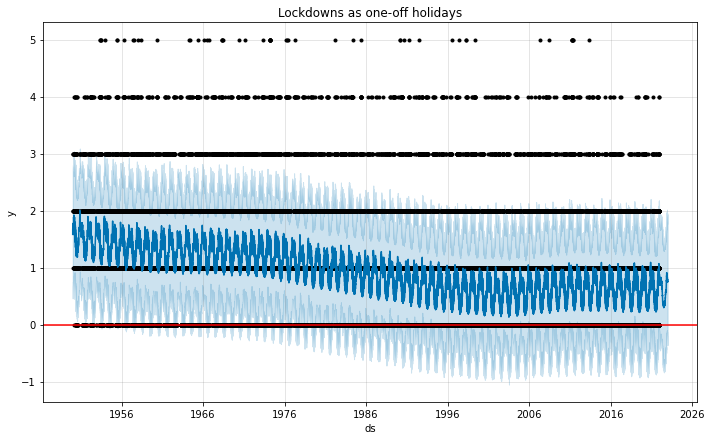

In [283]:

# Python
m.plot(forecast)
plt.axhline(y=0, color='red')
plt.title('Lockdowns as one-off holidays');


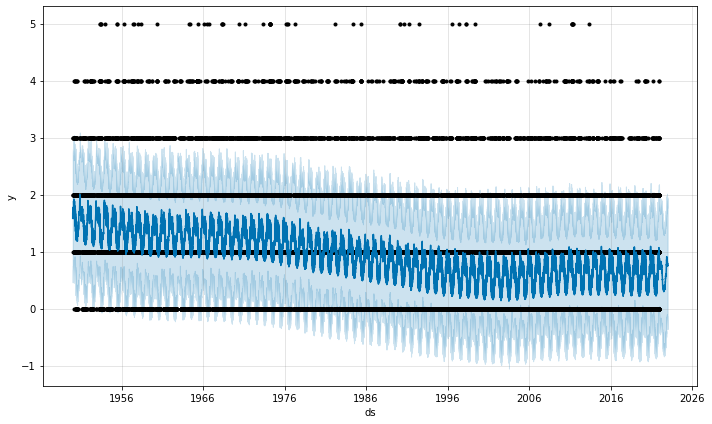

In [284]:
fig1 = m.plot(forecast)

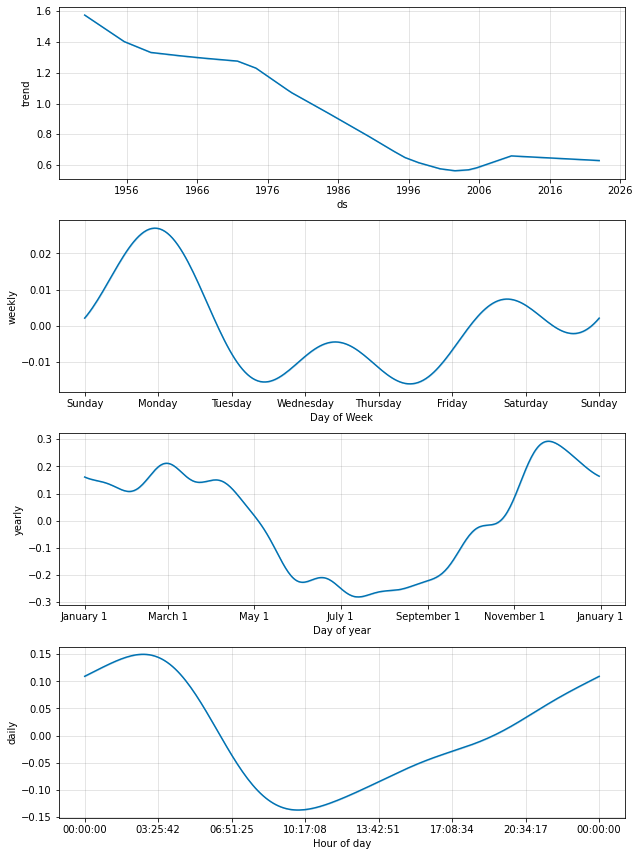

In [285]:
fig2 = m.plot_components(forecast)

In [1]:
# Python
plot_components_plotly(m, forecast)


NameError: name 'plot_components_plotly' is not defined